# Week 2 - Model Training

We will download the dataset prepared from the Dataset Preparation notebook and will begin model training to distinguish between the different main characters in Star Trek: The Next Generation

In [0]:
!wget -O tng.zip https://www.dropbox.com/s/3od3y6is3emoba0/tng_dataset.zip?dl=1

--2019-09-19 08:25:20--  https://www.dropbox.com/s/3od3y6is3emoba0/tng_dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/3od3y6is3emoba0/tng_dataset.zip [following]
--2019-09-19 08:25:26--  https://www.dropbox.com/s/dl/3od3y6is3emoba0/tng_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6d1958973df02d018a161d0325.dl.dropboxusercontent.com/cd/0/get/Ao2cEgcn-kGXo2CN9-UecF5PQ_SXbfPgtCn9If8NHsmRzEqgPUFnmxjY-ljp7EZVoUMy3HkV5H-9CUaW07Bm2DMP0qOj9H7UM6380DjwiAH5G4w2PDSuooNhFROg4eRlJ8U/file?dl=1# [following]
--2019-09-19 08:25:26--  https://uc6d1958973df02d018a161d0325.dl.dropboxusercontent.com/cd/0/get/Ao2cEgcn-kGXo2CN9-UecF5PQ_SXbfPgtCn9If8NHsmRzEqgPUFnmxjY-ljp7EZVoUMy3HkV5H-9CUaW07Bm2DMP0qOj9H7UM638

In [0]:
!unzip tng.zip

Archive:  tng.zip
   creating: beverly-crusher/
   creating: data/
   creating: deanna-troi/
   creating: geordi-la-forge/
   creating: jean-luc-picard/
   creating: katherine-pulaski/
   creating: tasha-yar/
   creating: wesley-crusher/
   creating: will-riker/
   creating: worf/
  inflating: deanna-troi.csv         
  inflating: will-riker.csv          
  inflating: .DS_Store               
  inflating: worf.csv                
  inflating: beverly-crusher.csv     
  inflating: katherine-pulaski.csv   
  inflating: jean-luc-picard.csv     
  inflating: data.csv                
  inflating: tasha-yar.csv           
  inflating: geordi-la-forge.csv     
  inflating: wesley-crusher.csv      
  inflating: jean-luc-picard/00000158.jpg  
  inflating: jean-luc-picard/00000170.jpg  
  inflating: jean-luc-picard/00000038.jpg  
  inflating: jean-luc-picard/00000004.jpg  
  inflating: jean-luc-picard/00000206.png  
  inflating: jean-luc-picard/00000213.jpg  
  inflating: jean-luc-picard/0000000

Let's import the relevant libraries

In [0]:
from fastai import *
from fastai.vision import *

Because we've extracted out the data in the current directory, the training directory is also here.  Let's create an `ImageDataBunch` with the current directory.

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder('.', train='.', valid_pct=0.1,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Let's take a look at the classes.

In [0]:
data.classes

['beverly-crusher',
 'data',
 'deanna-troi',
 'geordi-la-forge',
 'jean-luc-picard',
 'katherine-pulaski',
 'tasha-yar',
 'wesley-crusher',
 'will-riker',
 'worf']

Let's have a look at the actual images - show an example batch

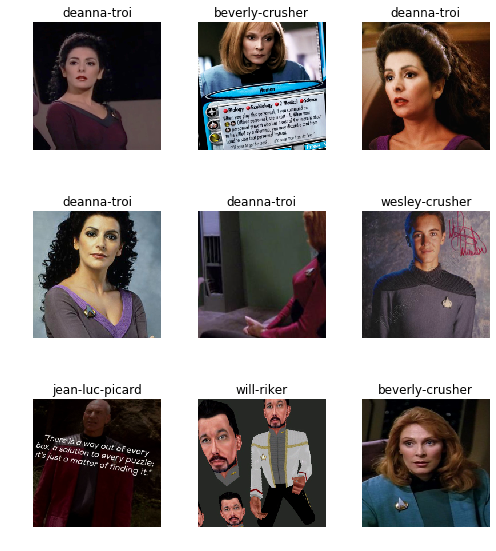

In [0]:
data.show_batch(rows=3, figsize=(7,8))

Show the number of classes, training and validation split

In [0]:
data.c, len(data.train_ds), len(data.valid_ds)

(10, 906, 100)

Load in ResNet34 and perform some transfer learning first

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 98057272.16it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.879290,0.978905,0.700000,0.300000,00:30
1,1.227635,0.810255,0.750000,0.250000,00:20
2,0.924675,0.858741,0.770000,0.230000,00:20
3,0.745924,0.832965,0.790000,0.210000,00:20


Save the model before we start to train the whole network.  After, let's try and find the best learning rates for the conv and dense layers.

In [0]:
learn.save('./stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


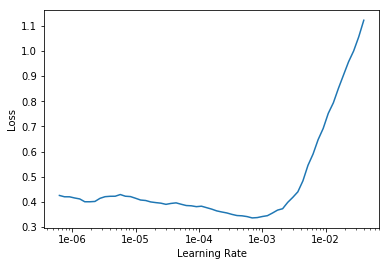

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.396801,0.756521,0.800000,0.200000,00:25
1,0.347490,0.686132,0.810000,0.190000,00:24
2,0.294243,0.590724,0.830000,0.170000,00:25
3,0.241342,0.564529,0.810000,0.190000,00:25
4,0.209778,0.704028,0.770000,0.230000,00:25
5,0.181956,0.824525,0.820000,0.180000,00:25
6,0.185449,0.932258,0.770000,0.230000,00:25
7,0.193438,1.149179,0.760000,0.240000,00:25
8,0.204441,0.768753,0.810000,0.190000,00:25
9,0.194637,0.859940,0.760000,0.240000,00:25


Good enough - requirements say 80% accurate.  Let's plot the confusion matrix to be sure


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

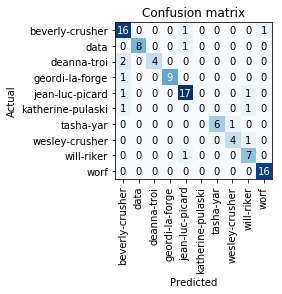

In [0]:
interp.plot_confusion_matrix()

Because the validation dataset is only 100 images, misclassifying 13 images out of the 100 to get the 87% accuracy is not bad.  Save the most recent model

In [0]:
learn.save('stage-2')

Now export the model for production

In [0]:
learn.export('./models/tng_model.pkl')

Let's test some pictures out

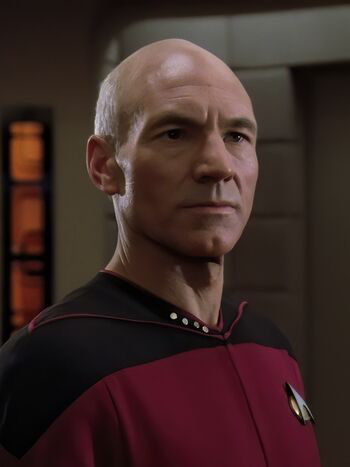

In [0]:
img = open_image('./jean-luc-picard/00000000.jpg')
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category jean-luc-picard

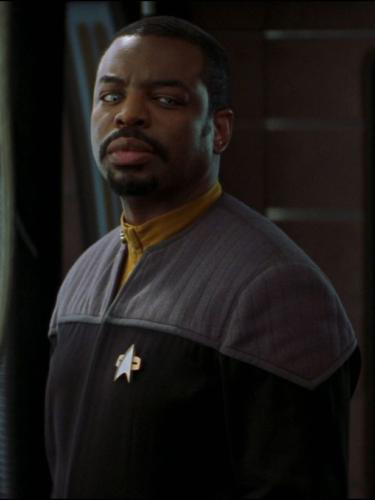

In [0]:
img = open_image('./geordi-la-forge/00000003.jpg')
img

In [0]:
pred_class,_,_ = learn.predict(img)
pred_class

Category geordi-la-forge

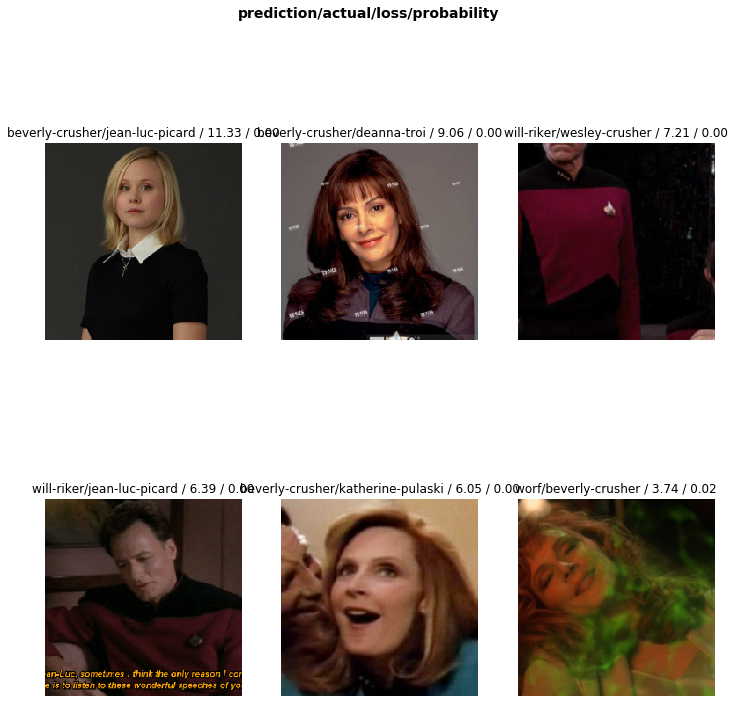

In [0]:
interp.plot_top_losses(6)